# Map Analysis II

###  Renée Hložek and Jeff McMahon

## Using our tools on real data

In this self study exercise, we are now going to use some public data from the ACT collaboration, compute power spectra and compare them to theory power spectra.

In [125]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import pylab as pl 


%cd /Users/eshaw/box/UTAustin_CMBSummerSchool/UT_Notebooks/
%matplotlib inline
import constants as cs # the constants module
from cmb_modules import * # the module of functions

N = cs.N
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = cs.atmospheric_noise_level
one_over_f_noise_level = cs.one_over_f_noise_level

C:\Users\eshaw\box\UTAustin_CMBSummerSchool\UT_Notebooks


# Reading in data and making simulated maps
Let's start by reading in a map and computing the power spectrum of the map, and then comparing to a theory map of a similar size/shape

0.49491833030853 0.49407681818181814
map mean: -3.5245380283448906 map rms: 311.228361194383


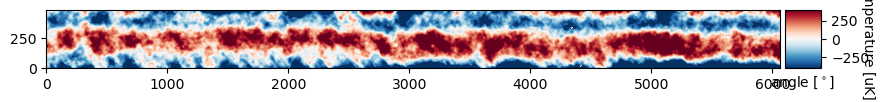

In [126]:
map = fits.getdata('ACT_Season3_148_GHz_submap.fits')
header = fits.getheader('ACT_Season3_148_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins
plt.figure(figsize=(10,10))
p = Plot_CMB_Map(map,c_min,c_max,Nx,Ny)


You can see that these ACT maps are long stripes, so we will cut a square patch out of the long strip and compute the PS on that patch.

map mean: 20.125159755016572 map rms: 124.47878213360549


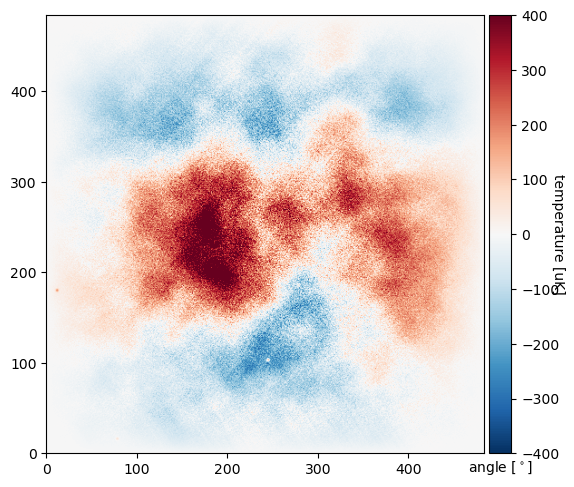

In [127]:
N=int(Ny) # take only one dimension
map_patch = map[0:int(N), 0:int(N)] #trimming the map down to size 
#Remember dimensions of these map are expressed (y,x) 


# Making a window function, taking the shorter dimension for now
window = (cosine_window(N))
appodized_map = window * map_patch

p=Plot_CMB_Map(appodized_map,c_min,c_max,N, N,figsize_x=6,figsize_y=6)


#### Q: We can see that there is a lot of power on large scales from the atmosphere. What do we expect to see in the power spectrum?

[Your thoughts here]

Let's make a theory map as we have in many other modules:

Number of sources required:  5000
Theory Map
map mean: -16.31587463935897 map rms: 55.09367174562662


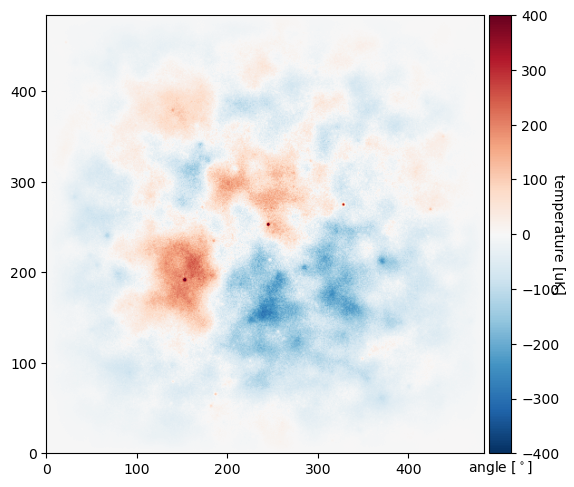

In [128]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 

CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

## make a point source map
PSMap = Poisson_source_component(N, pix_size, Number_of_Sources, Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N, pix_size, Number_of_Sources_EX, Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N, pix_size, Number_of_SZ_Clusters, Mean_Amplitude_of_SZ_Clusters, SZ_beta, SZ_Theta_core, False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorporate the impact of the instrument
    ## beam
CMB_T_convolved =convolve_map_with_gaussian_beam(N, pix_size, beam_size_fwhp, total_map)
    ## noise
Noise = make_noise_map(N, pix_size, white_noise_level, atmospheric_noise_level, one_over_f_noise_level)
total_map_plus_noise = CMB_T_convolved + Noise

## plot the result
appodized_theory_map = window * total_map_plus_noise
print('Theory Map')
p=Plot_CMB_Map(appodized_theory_map, c_min, c_max, N, N, figsize_x=6, figsize_y=6)


## We will now compare the power spectra of these two maps

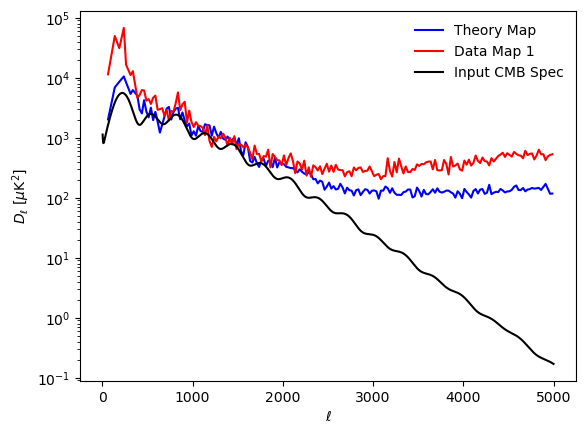

In [129]:
#### parameters for setting up the spectrum
delta_ell = 25.# cs.delta_ell
ell_max = int(cs.ell_max)
#ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
#plt.clf()

if max(ell)< ell_max: 
        print('WARNING: Your theory curves end before the binned ell_max')
        
binned_ell_theory, binned_spectrum_theory = \
    calculate_2d_spectrum(appodized_theory_map, delta_ell, ell_max, pix_size, N)
binned_ell_dat, binned_spectrum_dat = \
    calculate_2d_spectrum(appodized_map, delta_ell, ell_max, pix_size, N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, 'b',label='Theory Map')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, 'r',label='Data Map 1')
#plt.clf()

plt.semilogy(ell,DlTT, 'k', label = 'Input CMB Spec')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
leg = plt.legend()
leg.draw_frame(False)
plt.show()

#### Q: What are differences you can see between the sim map spectra and the data spectra?

[Your thoughts here]

#### Q: Notice that the power spectrum is biased high on large (and smallest) scales -- as we expected it to be. How might you remove that large scale power before computing the power spectrum? Will the destriping functionality of "Filter_Map" be useful here? 

[Your thoughts here]

The Filter_Map function in cmb_modules.py has options for masking ell values radially in fourier space, (so annular bins) as well as the destriping functionality. Use it to help you in the next few exercises.

<font color='red'>EXERCISE 1: </font>  Write code to filter out the large scale modes ell < ell_min before computing the power spectrum and show the spectra for a few different values for ell_min.
     (Suggestion: Start by plotting the 2D FFT of both maps to look at the noise in Fourier space)

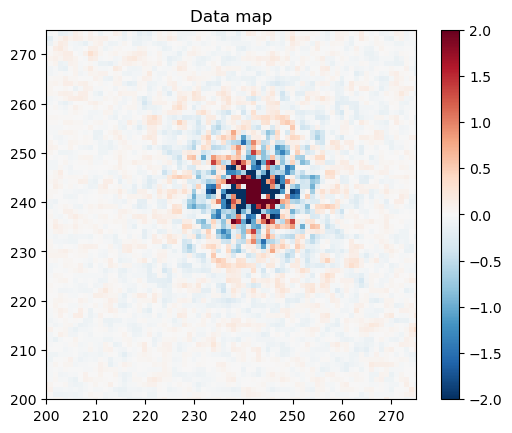

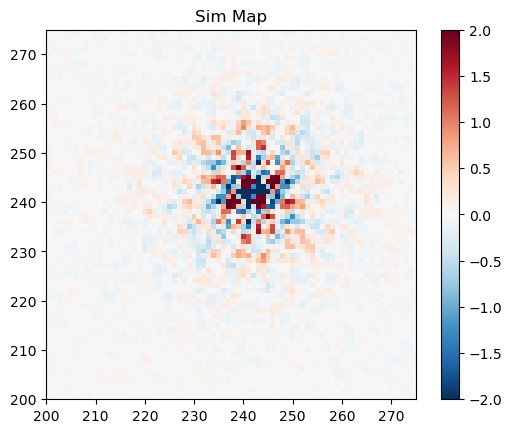

In [130]:
#Your code and plots here
#Lets first look at the 2D FFTs of the Maps.
import matplotlib.pylab as pl
zoommin, zoommax = 200, 275
vmin = -2
vmax= 2

FMap_1 = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(appodized_map)))
plt.figure()
plt.title('Data map')
im = pl.imshow(np.real(FMap_1), interpolation='none', origin='lower',cmap=cm.RdBu_r,vmin=vmin, vmax=vmax)
plt.xlim(zoommin, zoommax)
plt.ylim(zoommin, zoommax)
plt.colorbar()
plt.show()

FMap_2 = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(appodized_theory_map)))
plt.figure()
plt.title('Sim Map')
#fft_single= np.fft.fft2(map_single)
im = pl.imshow(np.real(FMap_2), interpolation='none', origin='lower',cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)
plt.xlim(zoommin, zoommax)
plt.ylim(zoommin, zoommax)
plt.colorbar()

In [131]:
def Plot_Mask_FMap(map, mask):
    # Input unfiltered map and the mask.
    #STEP BY STEP PLOTS
    plt.figure(figsize=(6,6))
    plt.title('Mask')
    plt.imshow(mask, interpolation='bilinear', origin='lower',cmap='seismic')
    #plt.xlim(N/2 - 50, N/2+50)
    #plt.ylim(N/2 - 50, N/2+50)
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.title('Fourier map')
    FMap = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(map)))
    plt.imshow(np.real(FMap),interpolation='bilinear',cmap='seismic',vmin=-3, vmax=3)
    #plt.xlim(N/2 - 50, N/2+50)
    #plt.ylim(N/2 - 50, N/2+50)
    plt.colorbar()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.imshow(np.real(FMap*mask),cmap='seismic',vmin=-3, vmax=3)
    plt.xlim(N/2 - 50, N/2+50)
    plt.ylim(N/2 - 50, N/2+50)
    plt.title('Fourier Map * mask')
    plt.colorbar()
    plt.show()
    FMap_filtered = FMap * mask
    filtered_map = np.real(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(FMap_filtered))))    
    plt.figure()
    plt.title('My Filtered Map')
    p=Plot_CMB_Map(filtered_map,c_min,c_max,N, N,figsize_x=6,figsize_y=6)


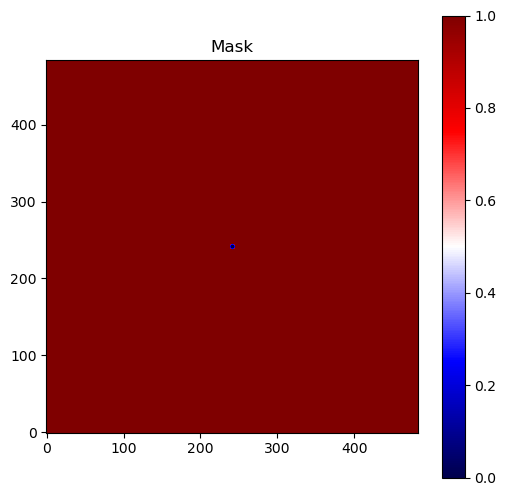

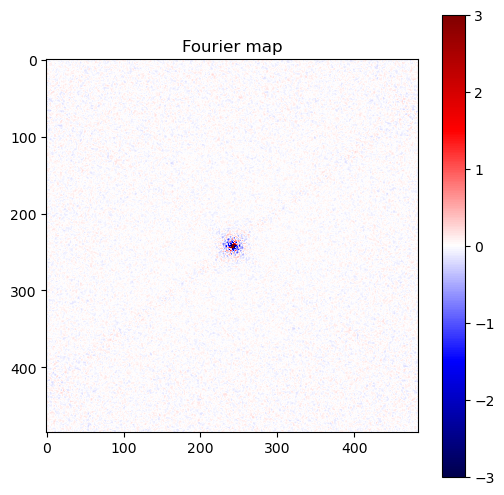

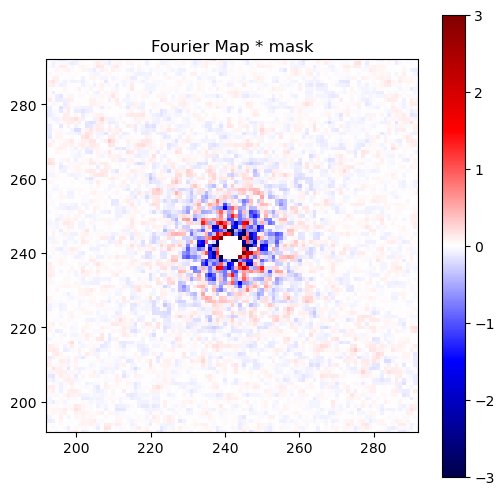

map mean: 1.9412409965442256e-16 map rms: 57.34015193855275


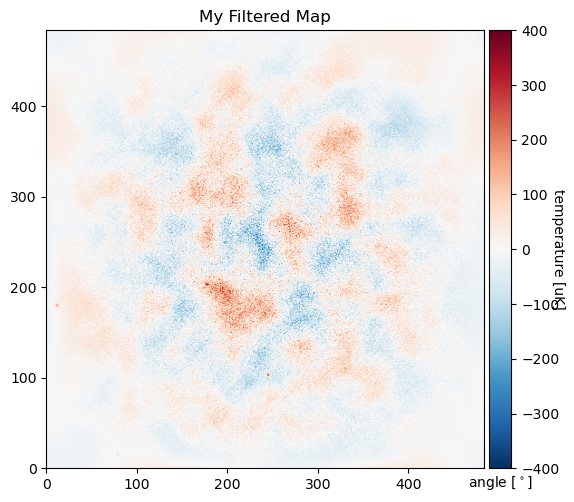

In [132]:
Map_Filtered, mask = Filter_Map_MultiMask(appodized_map, N, 0,0,3,return_mask=True)
Plot_Mask_FMap(appodized_map, mask)

map mean: 5.280175510600294e-16 map rms: 80.00322809370809


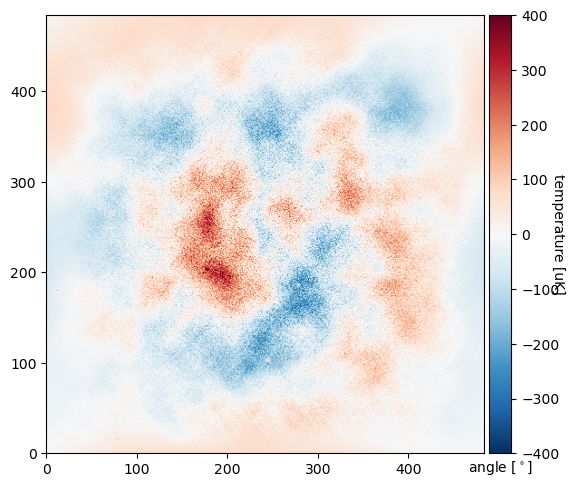

map mean: 20.125159755016572 map rms: 124.47878213360549


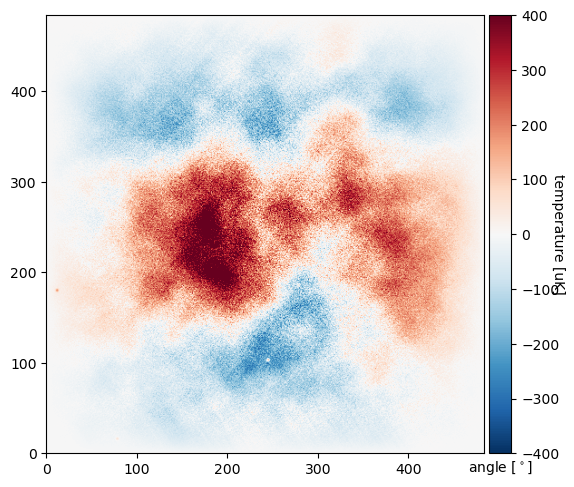

map mean: -16.31587463935897 map rms: 55.09367174562662


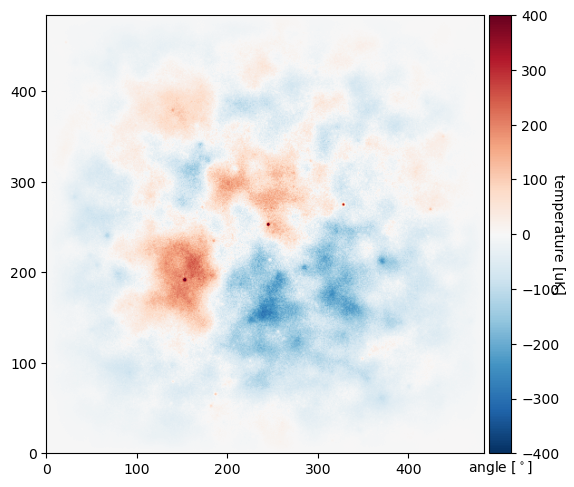

In [133]:
# Having chosen my favorite mask above, save the filtered map here, compare to data map.
Map_filtered1 = Filter_Map_MultiMask(appodized_map, N, 0,0,2)
p=Plot_CMB_Map(Map_filtered1,c_min,c_max,N, N,figsize_x=6,figsize_y=6)
p=Plot_CMB_Map(appodized_map,c_min,c_max,N, N,figsize_x=6,figsize_y=6)
p=Plot_CMB_Map(appodized_theory_map,c_min,c_max,N, N,figsize_x=6,figsize_y=6)

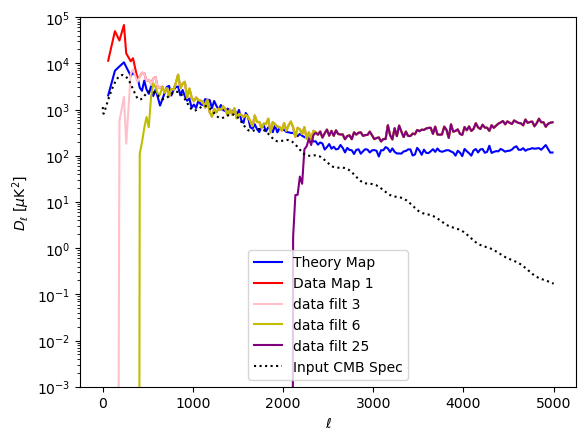

In [134]:
#Make Power Spectra of Filtered Maps

N1= 3
N2 = 6
N3 = 25
delta_ell=25
Map_filtered1 = Filter_Map_MultiMask(appodized_map, N, 0,0,N1)
Map_filtered2 = Filter_Map_MultiMask(appodized_map, N, 0,0,N2)
Map_filtered3 = Filter_Map_MultiMask(appodized_map, N, 0,0,N3)

#p=Plot_CMB_Map(Map_filtered1,c_min,c_max,N, N,figsize_x=6,figsize_y=6)
#calc spectra for three filtered maps
binned_ell_filt1, binned_spectrum_filt1 = calculate_2d_spectrum(Map_filtered1, delta_ell, ell_max, pix_size, N)
binned_ell_filt2, binned_spectrum_filt2 =  calculate_2d_spectrum(Map_filtered2, delta_ell, ell_max, pix_size, N)
binned_ell_filt3, binned_spectrum_filt3 =  calculate_2d_spectrum(Map_filtered3, delta_ell, ell_max, pix_size, N)

#Plot along with original data map
plt.semilogy(binned_ell_theory, binned_spectrum_theory * binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi, 'b', label='Theory Map')
plt.semilogy(binned_ell_dat, binned_spectrum_dat * binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, 'r',label='Data Map 1')
plt.semilogy(binned_ell_filt1, binned_spectrum_filt1 * binned_ell_filt1 * (binned_ell_filt1+1.)/2. / np.pi,c='pink', label=f'data filt {N1}')
plt.semilogy(binned_ell_filt2, binned_spectrum_filt2 * binned_ell_filt2 * (binned_ell_filt2+1.)/2. / np.pi, c='y',label=f'data filt {N2}')
plt.semilogy(binned_ell_filt3, binned_spectrum_filt3 * binned_ell_filt3 * (binned_ell_filt3+1.)/2. / np.pi, c='purple',label=f'data filt {N3}')
#plt.clf()

plt.semilogy(ell,DlTT, 'k:',label = 'Input CMB Spec')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.ylim(10**-3,10**5)
plt.legend()
plt.show()

<font color='red'>EXERCISE 2: </font> Think about how you might attempt to remove the ringing the power on small scales. Try a different appodization window and see how it affects your results. Discuss the shape of the apodising window and the large scale power leaking to small scales. 

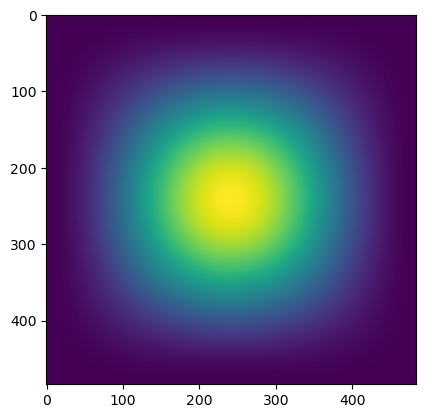

In [135]:
import scipy.signal.windows as ssw
def my_window(N):
    "A few different windows to try to avoid edges effects in the 2d FFT" 
    #https://en.wikipedia.org/wiki/Window_function
    window_map = np.outer(np.hanning(N), np.hanning(N))
    # return the window map
    return(window_map)

mywindow = my_window(N)
hanning_map = mywindow*map_patch
#kaiser_map  = mywindow*map_patch
#nuttall_map = mywindow * map_patch
#nuttall_map = mywindow * map_patch

plt.imshow(mywindow)
#p=Plot_CMB_Map(myappodized_map,c_min,c_max,N, N,figsize_x=2,figsize_y=2)

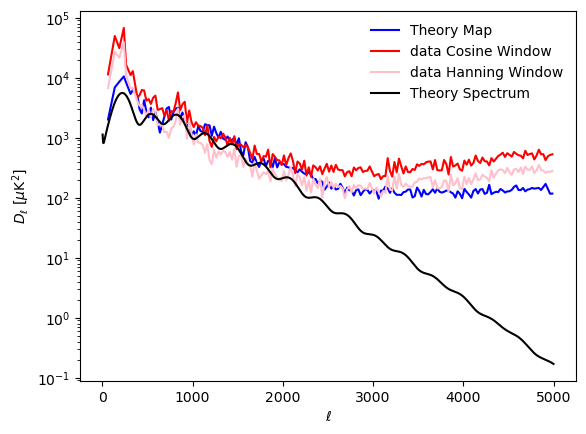

In [136]:
#Plot my new appodized map along with the old version.
mybinned_ell_dat, hanning_spectrum_dat = \
    calculate_2d_spectrum(hanning_map,delta_ell,ell_max,pix_size,N)
#mybinned_ell_dat, hamming_spectrum_dat = \
#    calculate_2d_spectrum(hamming_map,delta_ell,ell_max,pix_size,N)
#mybinned_ell_dat, nuttall_spectrum_dat = \
#    calculate_2d_spectrum(nuttall_map,delta_ell,ell_max,pix_size,N)
#mybinned_ell_dat, kaiser_spectrum_dat = \
#    calculate_2d_spectrum(kaiser_map,delta_ell,ell_max,pix_size,N)

#print binned_ell, binned_spectrum
#print np.mean(binned_ell), np.shape(binned_ell), np.max(binned_ell), np.min(binned_ell)
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi,'b', label='Theory Map')
plt.semilogy(binned_ell_dat,binned_spectrum_dat*\
                binned_ell_dat * (mybinned_ell_dat+1.)/2. / np.pi, 'r',label='data Cosine Window')
#plt.semilogy(mybinned_ell_dat, kaiser_spectrum_dat*\
#                mybinned_ell_dat * (mybinned_ell_dat+1.)/2. / np.pi,'c', label='data Kaiser Window')
#plt.semilogy(mybinned_ell_dat, nuttall_spectrum_dat*\
#                mybinned_ell_dat * (mybinned_ell_dat+1.)/2. / np.pi, label='data Nuttall Window')
#plt.semilogy(mybinned_ell_dat, hamming_spectrum_dat*\
#                mybinned_ell_dat * (mybinned_ell_dat+1.)/2. / np.pi,'c', label='data Hamming Window')
plt.semilogy(mybinned_ell_dat, hanning_spectrum_dat*\
                mybinned_ell_dat * (mybinned_ell_dat+1.)/2. / np.pi,c='pink', label='data Hanning Window')
plt.semilogy(ell,DlTT, 'k',label = 'Theory Spectrum')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
leg = plt.legend()
leg.draw_frame(False)
plt.show()

Looks like I was moderately sucessful. Hanning is lower than cosine bias on small scales.

<font color='red'>EXCERCISE 3: </font>  We cut out a particular patch from the ACT strip above. Cut out different patches and view the maps. 

In [137]:
##Make subdivided maps
window = cosine_window(N)
N=int(Ny) 
delta_ell = 25
#print(f'Breaking long strip map into {Nx//Ny} smaller maps')

skypatch_data = {} #dictionary to hold maps and spectra
for patch in range(Nx//Ny):
    patchmap = map[0:int(N), (patch)*int(N):(patch+1)*int(N)]
    appodized_map = window * patchmap
       
    this_patch_autospectrum = calculate_2d_spectrum(appodized_map,delta_ell,ell_max,pix_size,N)
    skypatch_data[patch]={'appmap': appodized_map, 'spectrum': this_patch_autospectrum}
    #Uncomment to  view maps
    #p=Plot_CMB_Map(appodized_map,c_min,c_max,N, N,figsize_x=6, figsize_y=6)

<font color='red'>EXCERCISE 4: </font>  Now you'll calculate the power spectra of all the different maps. 
By using the power spectrum code in the modules file, compute and plot both the auto and the cross spectra for the maps, along with the averages.

Text(0.5, 0, '$\\ell$')

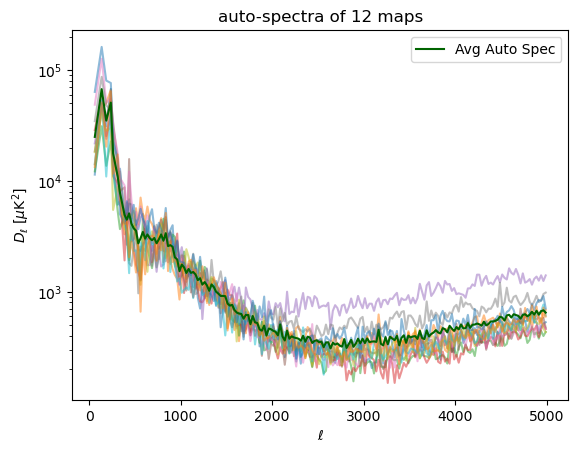

In [138]:
#turn power spectra data from dictionary above into an array.
patch_autospectra = np.array([skypatch_data[patch]['spectrum'][1] for patch in skypatch_data.keys()])

#calculate mean and rms of auto spectras
mean_autospectra, rms_autospectra = average_N_spectra(patch_autospectra,np.shape(patch_autospectra)[0],np.shape(patch_autospectra)[1]) #int(ell_max/delta_ell))
ellsb = skypatch_data[0]['spectrum'][0] #pull out ell bins ((same as binned_ells_dat etc above)

plt.figure()
plt.title('auto-spectra of 12 maps')
for key in skypatch_data.keys():
    plt.semilogy(ellsb, skypatch_data[key]['spectrum'][1]*(ellsb*(ellsb+1))/2./np.pi, alpha=0.5)
plt.semilogy(ellsb, mean_autospectra*(ellsb*(ellsb+1))/2./np.pi,\
             'darkgreen', label='Avg Auto Spec')
plt.legend(loc=0)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')

In [139]:
## Now move on to cross spectra
num_maps = Nx//Ny
num_spec = int((num_maps*(num_maps-1))/2)
print(f'Making {int(num_spec)} cross spectra')

xspec_data = np.zeros((int(num_spec),int(len(ellsb))))

ind = 0
for first_map in range(num_maps): #loop over all our maps
    for second_map in range(num_maps):
        if first_map > second_map:
            map1 = skypatch_data[first_map]['appmap'] #alrady appodized
            map2 = skypatch_data[second_map]['appmap']
            #calculate_2d_spectrum(appodized_map,delta_ell,ell_max,pix_size,N)
            _, cls = calculate_2d_spectrum(map1, delta_ell, ell_max,\
                                              pix_size, N, Map2=map2)
          
            #Filter_Map_MultiMask(appodized_map, N, 0,0,N1)
            xspec_data[ind]=cls
            ind +=1

mean_xspectra, rms_xspectra = average_N_spectra(xspec_data,np.shape(xspec_data)[0],np.shape(xspec_data)[1]) 

Making 66 cross spectra


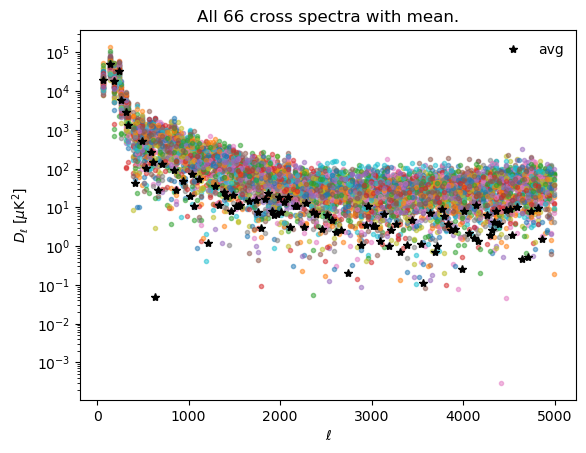

In [140]:
plt.figure()
for s in range(num_spec):
    plt.semilogy(ellsb, xspec_data[s]*ellsb*(ellsb+1)/2./np.pi,'.',alpha=0.5)
plt.semilogy(ellsb, mean_xspectra*ellsb*(ellsb+1)/2./np.pi,'k*',label = 'avg')
leg = plt.legend()
leg.draw_frame(False)

plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.title('All 66 cross spectra with mean.')
plt.show()

Text(0.5, 0, '$\\ell$')

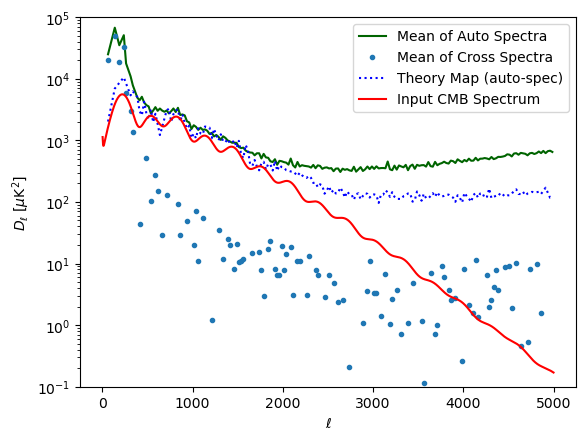

In [141]:
plt.figure()
plt.semilogy(ellsb, mean_autospectra*(ellsb*(ellsb+1))/2./np.pi,c='darkgreen', label='Mean of Auto Spectra')
plt.semilogy(ellsb, (mean_xspectra)*ellsb*(ellsb+1)/2./np.pi, '.', label = 'Mean of Cross Spectra')
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi,'b:', label='Theory Map (auto-spec)')
#plt.errorbar(x=ellsb, y=mean_autospectra*ellsb*(ellsb+1)/2./np.pi, yerr = rms_xspectra*ellsb*(ellsb+1)/2./np.pi, elinewidth=2,ecolor='k',label = 'mean auto spectrum from 12 maps\n with err bars from cross spectra rms')
#plt.semilogy(ellsb, (mean_autospectra-mean_xspectra)*ellsb*(ellsb+1)/2./np.pi, label = 'auto - cross')
plt.semilogy(ell,DlTT, 'r',label = 'Input CMB Spectrum')
plt.ylim(10**-1, 10**5)
plt.legend()
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')

In a cross spectrum between two independent maps of the same patch of sky, the mean noise bias is zero.

<$\hat D$> = <$T*D_{\ell} + N$> = <$T*D_{\ell}$>. 

Thus the mean of all the crosses gives an estimate of the true band power, and the rms of the crosses gives an estimate on the error bars, without the risk of bias from an incorrect noise model.

This isn't applicable here, since the maps made from the long ACT map strip aren't of the same sky, but it is a cool concept.

Here is the plot of error bars on the cross spectra anyway.

Text(0.5, 0, '$\\ell$')

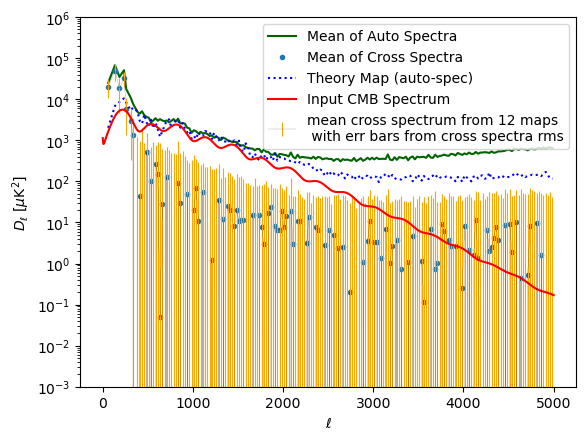

In [142]:
plt.figure()
plt.semilogy(ellsb, mean_autospectra*(ellsb*(ellsb+1))/2./np.pi,'darkgreen', label='Mean of Auto Spectra')
plt.semilogy(ellsb, (mean_xspectra)*ellsb*(ellsb+1)/2./np.pi, '.', label = 'Mean of Cross Spectra')
plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi,'b:', label='Theory Map (auto-spec)')
plt.errorbar(x=ellsb, y=mean_xspectra*ellsb*(ellsb+1)/2./np.pi, yerr = rms_xspectra*ellsb*(ellsb+1)/2./np.pi, lw=0.1,color = 'k', elinewidth=.8,ecolor='orange',label = 'mean cross spectrum from 12 maps\n with err bars from cross spectra rms')
plt.semilogy(ell,DlTT, 'r',label = 'Input CMB Spectrum')
plt.ylim(10**-3, 10**6)
plt.legend(loc=1)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')

<font color='red'>EXCERCISE 5: </font>
Lets make an estimate for the noise in the ACT maps by changing the noise levels injected into noise-only sims. Plot noise curves for a few values and show here. (Add noise_only_sims to some signal_only sims). Do a simple "by-eye" estimate of the noise level. What does that tell you about real-world noise from CMB Experiments?

Be careful if you copy code directly from Part_4, the definition of calculate_2d_spectrum is slightly different in the cmb_modules.py script than from yesterday.

In [143]:
## try to make signal only sim
N_iterations = 16

signal_only  = np.zeros([N_iterations,len(ellsb)])
i = 0
#beam_size_fwhp = 12.
while (i <N_iterations):
    CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)
    total_map = CMB_T
    CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(window*CMB_T_convolved,delta_ell,ell_max,pix_size,N)
    signal_only[i] = binned_spectrum_cur
    sys.stdout.write("\r signal only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

sig_only_mean_spectrum, rms_not_needed = average_N_spectra(signal_only,N_iterations,len(ellsb)) #Cls

 signal only sims, iterations complete: 16 of 16

In [144]:
# Your code here (FROM PART 4)
N_iterations = 16

print(white_noise_level)
print(atmospheric_noise_level)
print(one_over_f_noise_level)

10.0
0.0
0.0


In [145]:
noise_only  = np.zeros([N_iterations,len(ellsb)])
i = 0
while (i <N_iterations):
    Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(Map=Noise*window, Map2=Noise*window, 
                                                                delta_ell=delta_ell, ell_max=ell_max, pix_size=pix_size,N=N)
    noise_only[i,:] = binned_spectrum_cur
    sys.stdout.write("\r noise only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

noise_only_mean_spectrum_1, rms_not_needed = average_N_spectra(noise_only,N_iterations,N_ells = len(ellsb))

 noise only sims, iterations complete: 16 of 16

In [146]:
white_noise_level=15
atmospheric_noise_level=0.1
noise_only  = np.zeros([N_iterations,len(ellsb)])
i = 0
while (i <N_iterations):
    Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    binned_ell_cur, binned_spectrum_cur = calculate_2d_spectrum(Map=Noise*window, Map2=Noise*window, 
                                                                delta_ell=delta_ell, ell_max=ell_max, pix_size=pix_size,N=N)
    noise_only[i,:] = binned_spectrum_cur
    sys.stdout.write("\r noise only sims, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    i = i + 1

noise_only_mean_spectrum_2, rms_not_needed = average_N_spectra(noise_only,N_iterations,N_ells = len(ellsb))

 noise only sims, iterations complete: 16 of 16

(10, 10000)

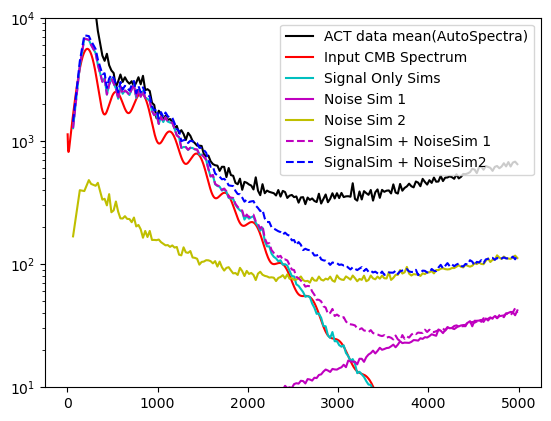

In [147]:
plt.figure()
plt.semilogy(ellsb, mean_autospectra*(ellsb*(ellsb+1))/2./np.pi,'k', label='ACT data mean(AutoSpectra)')
plt.semilogy(ell,DlTT, 'r',label = 'Input CMB Spectrum')
#plt.semilogy(binned_ell_theory,binned_spectrum_theory*\
#                 binned_ell_theory * (binned_ell_theory+1.)/2. / np.pi,'b', label='Theory Map')
plt.semilogy(ellsb, sig_only_mean_spectrum*(ellsb*(ellsb+1))/2./np.pi, c = 'c', label = 'Signal Only Sims')
plt.semilogy(ellsb, noise_only_mean_spectrum_1*(ellsb*(ellsb+1))/2./np.pi, c = 'm', label = 'Noise Sim 1')
plt.semilogy(ellsb, noise_only_mean_spectrum_2*(ellsb*(ellsb+1))/2./np.pi, c = 'y', label = 'Noise Sim 2')

plt.semilogy(ellsb, (sig_only_mean_spectrum+noise_only_mean_spectrum_10uk)*(ellsb*(ellsb+1))/2./np.pi, '--',c='m',label = 'SignalSim + NoiseSim 1' )
plt.semilogy(ellsb, (sig_only_mean_spectrum+noise_only_mean_spectrum_15uk_atmo0p3)*(ellsb*(ellsb+1))/2./np.pi, '--',c='b',label = 'SignalSim + NoiseSim2' )

plt.legend()
plt.ylim(10**1, 10**4)

Your discussion here

In [148]:
## Your code here

## Frequency dependence of maps and foregrounds

Now we are going to look at ACT maps on the same patch of the sky, but in a different frequency band.

0.49491833030853 0.49407681818181814
map mean: -35.148097186618045 map rms: 319.0813587167169


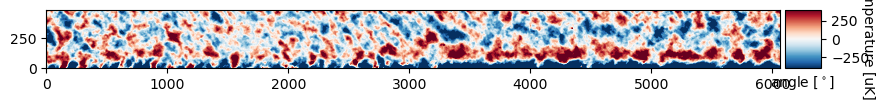

In [149]:
map220 = fits.getdata('ACT_Season3_220_GHz_submap.fits')
header = fits.getheader('ACT_Season3_220_GHz_submap.fits')
ra0 = 310.006000
ra1 = 360.001000
dec0 = -1.996904
dec1 = 1.988649
Nx= header['NAXIS1']
Ny= header['NAXIS2']

pix_x = 60.*(ra1-ra0)/Nx
pix_y = 60.*(dec1-dec0)/Ny
print(pix_x, pix_y) # x and y pixel scales in arcmins
plt.figure(figsize=(10,10))
p = Plot_CMB_Map(map220,c_min,c_max,Nx,Ny)


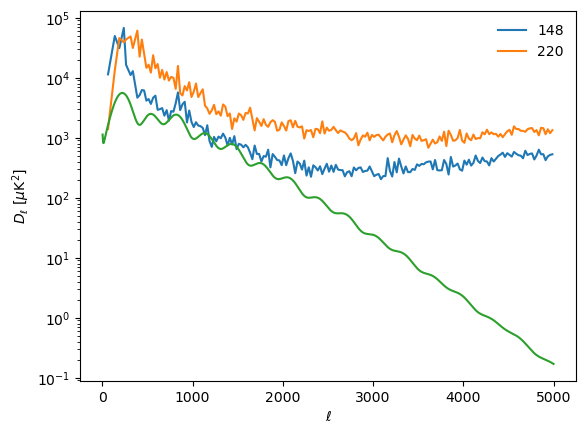

In [150]:
N=int(Ny) # take only one dimension
map_patch220 = map220[0:int(N), 0:int(N)] #trimming the map down to size
window = (cosine_window(N))
appodized_map220 = window * map_patch220

binned_ell_dat220, binned_spectrum_dat220 = calculate_2d_spectrum(appodized_map220,delta_ell,ell_max,pix_size,N)
plt.semilogy(binned_ell_dat,binned_spectrum_dat* binned_ell_dat * (binned_ell_dat+1.)/2. / np.pi, label='148')
plt.semilogy(binned_ell_dat220,binned_spectrum_dat220* binned_ell_dat220 * (binned_ell_dat220+1.)/2. / np.pi, label='220')
#plt.clf()
leg = plt.legend()
leg.draw_frame(False)
plt.semilogy(ell,DlTT)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]')
plt.xlabel('$\ell$')
plt.show()

<font color='red'>EXERCISE 5: </font> The spectrum is biased high from point sources on all scales. Use the code from the previous notebook to determine the noise bias for this spectrum and remove it.

In [151]:
## Your code here